In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain as community  # Assurez-vous que c'est le bon module pour 'community'.
from collections import Counter
from node2vec import Node2Vec
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, accuracy_score, adjusted_rand_score, normalized_mutual_info_score, jaccard_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import random
import pandas as pd
from itertools import combinations

c:\Users\becko\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
file_path = 'graphs/FB/facebook_combined.txt'


G = nx.Graph()


with open(file_path, 'r') as file:
    for line in file:
        node1, node2 = map(int, line.strip().split())
        G.add_edge(node1, node2)

fb_n_unique = G.number_of_nodes()
fb_k = G.number_of_edges()
fb_avg_deg = 2 * fb_k / fb_n_unique 

print('Nombre de nœuds :', fb_n_unique)
print('Nombre de liens :', fb_k)
print('Degré moyen :', fb_avg_deg)


Nombre de nœuds : 4039
Nombre de liens : 88234
Degré moyen : 43.69101262688784


**degree distribution** 

Text(0.5, 1.0, 'Degree distribution')

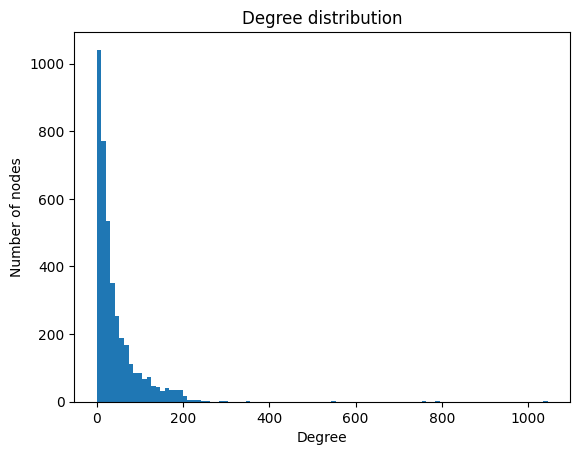

In [5]:
degrees = dict(G.degree()).values() 
degree_hist = plt.hist(degrees, 100)
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Degree distribution')

In [6]:
print('# connected components of Facebook network: ', nx.number_connected_components(G))

# connected components of Facebook network:  1


## Centrality

In [7]:
fb=G

In [8]:
betweenness_fb = nx.betweenness_centrality(fb)
closeness_fb = nx.closeness_centrality(fb)
eigencentrality_fb = nx.eigenvector_centrality(fb)
degree_cent_fb = nx.degree_centrality(fb)


# Extraction des top 100 nœuds pour chaque type de centralité
top_betweenness = set(sorted(betweenness_fb, key=betweenness_fb.get, reverse=True)[:100])
top_closeness = set(sorted(closeness_fb, key=closeness_fb.get, reverse=True)[:100])
top_eigencentrality = set(sorted(eigencentrality_fb, key=eigencentrality_fb.get, reverse=True)[:100])
top_degree = set(sorted(degree_cent_fb, key=degree_cent_fb.get, reverse=True)[:100])

# Création d'une liste pour faciliter l'itération
top_nodes_lists = [top_betweenness, top_closeness, top_eigencentrality, top_degree]
labels = ["Betweenness", "Closeness", "Eigenvector", "Degree"]

# Calcul de la matrice de pourcentage commun
percentage_matrix = [[None for _ in range(4)] for _ in range(4)]

for i in range(4):
    for j in range(4):
        if i == j:
            # Le pourcentage commun avec soi-même est de 100%
            percentage_matrix[i][j] = 100.0
        else:
            # Calcul du pourcentage de nœuds communs
            common_nodes = len(top_nodes_lists[i].intersection(top_nodes_lists[j]))
            unique_nodes = len(top_nodes_lists[i].union(top_nodes_lists[j]))
            percentage_matrix[i][j] = common_nodes

# Affichage de la matrice
for i, row in enumerate(percentage_matrix):
    print(f"{labels[i]}: {row}")


Betweenness: [100.0, 26.582278481012654, 2.564102564102564, 8.108108108108109]
Closeness: [26.582278481012654, 100.0, 0.5025125628140703, 5.82010582010582]
Eigenvector: [2.564102564102564, 0.5025125628140703, 100.0, 47.05882352941176]
Degree: [8.108108108108109, 5.82010582010582, 47.05882352941176, 100.0]


C:\Users\becko\AppData\Local\Temp\ipykernel_288\347495137.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels, rotation=45, ha="left")
C:\Users\becko\AppData\Local\Temp\ipykernel_288\347495137.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


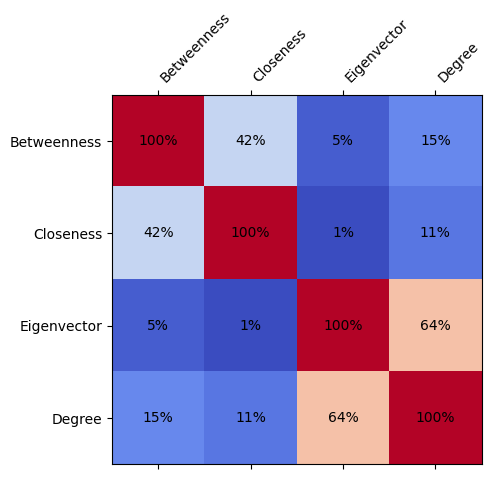

In [18]:
percentage_matrix = [
    [100,42,5,15],
    [42,100,1,11],
    [5,1,100,64],
    [15,11,64,100]
]

# Conversion de la matrice en un tableau numpy
data = np.array(percentage_matrix)

# Noms des méthodes de centralité
labels = ["Betweenness", "Closeness", "Eigenvector", "Degree"]

fig, ax = plt.subplots()
cax = ax.matshow(data, cmap="coolwarm")


# Définition des étiquettes pour les axes
ax.set_xticklabels([''] + labels, rotation=45, ha="left")
ax.set_yticklabels([''] + labels)

# Ajout d'annotations pour chaque cellule
for (i, j), val in np.ndenumerate(data):
    ax.text(j, i, f'{val:}%', va='center', ha='center')

plt.show()

The function nx.spring_layout returns the position of the nodes using the Fruchterman–Reingold force-directed algorithm.
This algorithm distributes the graph nodes in such a way that all the edges are more or less equally long and they cross themselves as few times as possible. Moreover, we can change the size of the nodes to that defined by their degree centrality. 

In [141]:
pos_fb = nx.spring_layout(fb, iterations = 1000)

In [142]:
np.save('graphs/FB/pos_fb.npy', pos_fb)

In [3]:
pos_fb = np.load('graphs/FB/pos_fb.npy', allow_pickle=True).item()

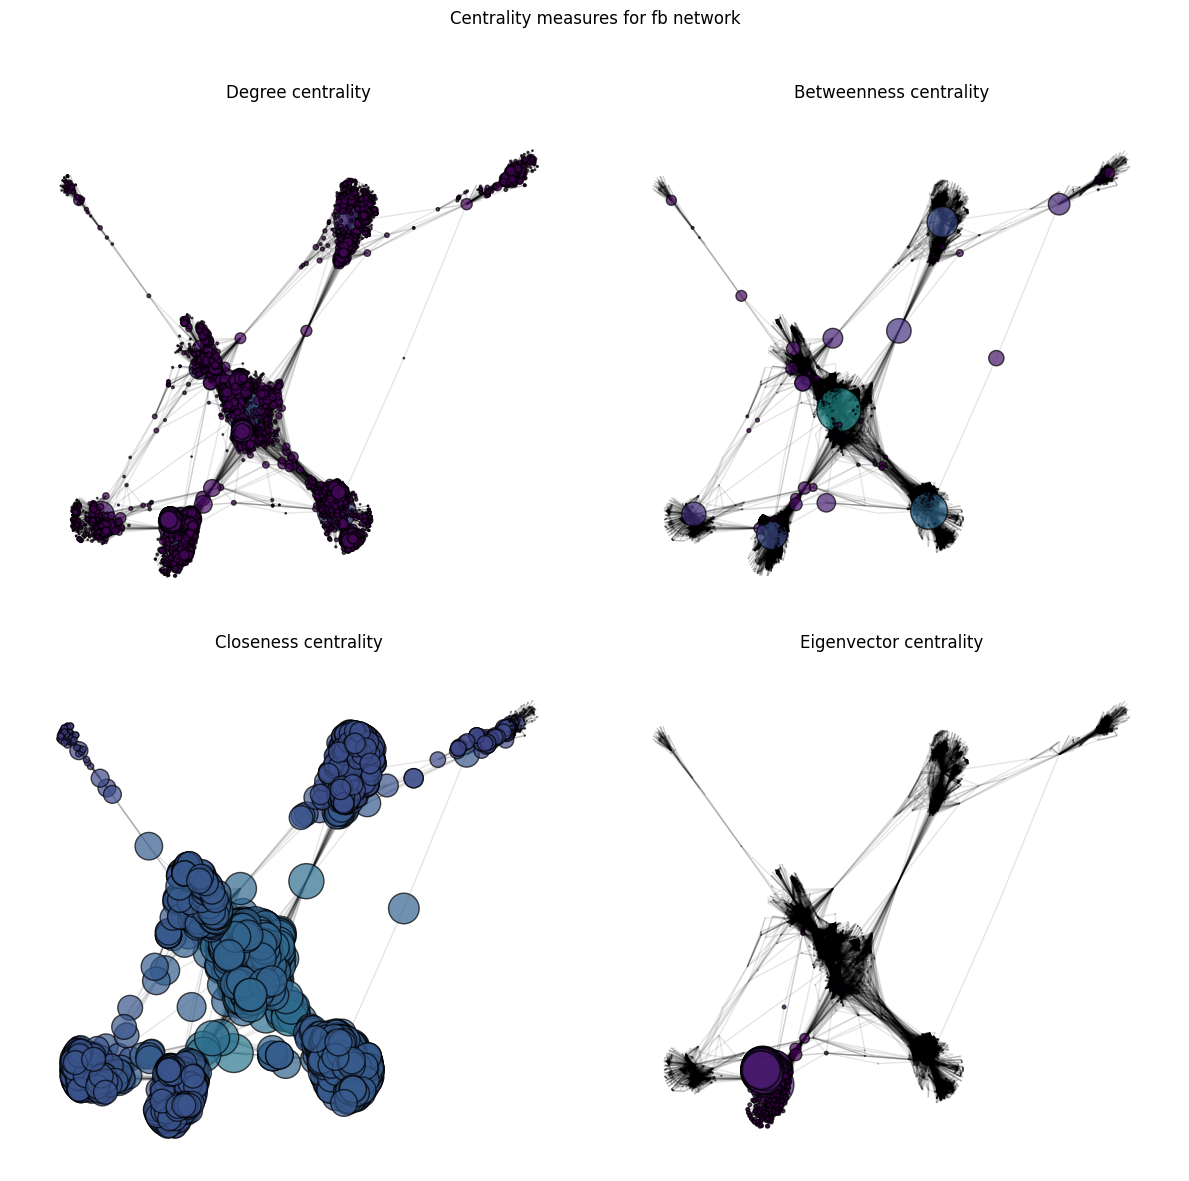

In [18]:
import matplotlib.cm as cm
import matplotlib.colors as colors
cte=1000
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('Centrality measures for fb network')

# Création d'une échelle de couleurs
cmap = cm.viridis

# Utiliser une normalisation commune pour toutes les mesures de centralité
norm = colors.Normalize(vmin=0, vmax=1)

# Degree centrality:
nsize = np.array([v for v in degree_cent_fb.values()])
nsize = cte*(nsize - min(nsize))/(max(nsize) - min(nsize))
colors = [cmap(norm(value)) for value in degree_cent_fb.values()]
nodes = nx.draw_networkx_nodes(fb, pos=pos_fb, node_size=nsize, node_color=colors, edgecolors='black', alpha=.7, ax=ax[0,0])
edges = nx.draw_networkx_edges(fb, pos=pos_fb, alpha=.1, ax=ax[0,0])
ax[0,0].set_title('Degree centrality')
ax[0,0].axis('off')

# Betweenness centrality:
nsize = np.array([v for v in betweenness_fb.values()])
nsize = cte*(nsize - min(nsize))/(max(nsize) - min(nsize))
colors = [cmap(norm(value)) for value in betweenness_fb.values()]
nodes = nx.draw_networkx_nodes(fb, pos=pos_fb, node_size=nsize, node_color=colors, edgecolors='black', alpha=.7, ax=ax[0,1])
edges = nx.draw_networkx_edges(fb, pos=pos_fb, alpha=.1, ax=ax[0,1])
ax[0,1].set_title('Betweenness centrality')
ax[0,1].axis('off')

# Closeness centrality:
nsize = np.array([v for v in closeness_fb.values()])
nsize = cte*(nsize - min(nsize))/(max(nsize) - min(nsize))
colors = [cmap(norm(value)) for value in closeness_fb.values()]
nodes = nx.draw_networkx_nodes(fb, pos=pos_fb, node_size=nsize, node_color=colors, edgecolors='black', alpha=.7, ax=ax[1,0])
edges = nx.draw_networkx_edges(fb, pos=pos_fb, alpha=.1, ax=ax[1,0])
ax[1,0].set_title('Closeness centrality')
ax[1,0].axis('off')

# Eigenvector centrality:
nsize = np.array([v for v in eigencentrality_fb.values()])
nsize = cte*(nsize - min(nsize))/(max(nsize) - min(nsize))
colors = [cmap(norm(value)) for value in eigencentrality_fb.values()]
nodes = nx.draw_networkx_nodes(fb, pos=pos_fb, node_size=nsize, node_color=colors, edgecolors='black', alpha=.7, ax=ax[1,1])
edges = nx.draw_networkx_edges(fb, pos=pos_fb, alpha=.1, ax=ax[1,1])
ax[1,1].set_title('Eigenvector centrality')
ax[1,1].axis('off')

# Afficher la figure
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Ajuster l'espace pour le titre global
plt.show()


## Community detection

### Louvain Communities


In [93]:
partition = community.best_partition(fb)
print('Modularity:', community.modularity(partition, fb))


communities = Counter(partition.values())
print('Number of communities:', len(communities))
print('Size of the communities:', communities)

# Creating a reverse mapping from nodes to their communities
node_to_community = {node: com for node, com in partition.items()}
# Count inter-community edges
inter_community_edges = sum(1 for edge in G.edges() if node_to_community[edge[0]] != node_to_community[edge[1]])
print(f"Number of inter-community edges: {inter_community_edges}")


Modularity: 0.8349714021924082
Number of communities: 16
Size of the communities: Counter({9: 548, 4: 535, 2: 435, 1: 430, 3: 423, 0: 350, 5: 325, 11: 237, 8: 226, 14: 206, 6: 128, 10: 73, 13: 60, 12: 25, 15: 19, 7: 19})
Number of inter-community edges: 3446


In [94]:
partition.items()

dict_items([(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (33, 0), (34, 1), (35, 0), (36, 0), (37, 0), (38, 0), (39, 0), (40, 0), (41, 0), (42, 0), (43, 0), (44, 0), (45, 0), (46, 0), (47, 0), (48, 0), (49, 0), (50, 0), (51, 0), (52, 0), (53, 0), (54, 0), (55, 0), (56, 0), (57, 0), (58, 0), (59, 0), (60, 0), (61, 0), (62, 0), (63, 0), (64, 0), (65, 0), (66, 0), (67, 0), (68, 0), (69, 0), (70, 0), (71, 0), (72, 0), (73, 0), (74, 0), (75, 0), (76, 0), (77, 0), (78, 0), (79, 0), (80, 0), (81, 0), (82, 0), (83, 0), (84, 0), (85, 0), (86, 0), (87, 0), (88, 0), (89, 0), (90, 0), (91, 0), (92, 0), (93, 0), (94, 0), (95, 0), (96, 0), (97, 0), (98, 0), (99, 0), (100, 0), (101, 0), (102, 0), (103, 0), (104, 0), (105, 0), (106, 0), (107, 2), (108, 0), (109, 0)

### K-mean detection of communities on the embeddings from node2vec approach

Phase 1: Preprocessing pour calculer les probabilités de transition pour les parcours aléatoires puis phase 2 : simulation de ces parcours aléatoires pour générer les embeddings des noeuds.

In [22]:
# Initialisation de Node2Vec avec des paramètres spécifiques
node2vec = Node2Vec(G, dimensions=64, walk_length=10, num_walks=100, workers=4) 




Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

Computing transition probabilities: 100%|██████████| 4039/4039 [01:27<00:00, 46.13it/s] 


In [24]:
# Générer des marches aléatoires
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [95]:
model.wv.save_word2vec_format("graphs/FB/fb_embeddings.emb")

In [96]:
embeddings = KeyedVectors.load_word2vec_format("graphs/FB/fb_embeddings.emb")

Visualisation : Reduction de dim puis matplotlib

In [97]:
embeddings_list = np.array(list(embeddings.vectors))

# Utilisation de t-SNE pour réduire la dimensionnalité
tsne = TSNE(n_components=2, random_state=7)
embeddings_2d = tsne.fit_transform(embeddings_list)

plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.show()


Ajout d'un kmeans pour clusturing et faire ressortir les communautés

In [98]:
node_ids = embeddings.index_to_key  # Identifiants de nœuds à partir des embeddings
vectors = embeddings.vectors

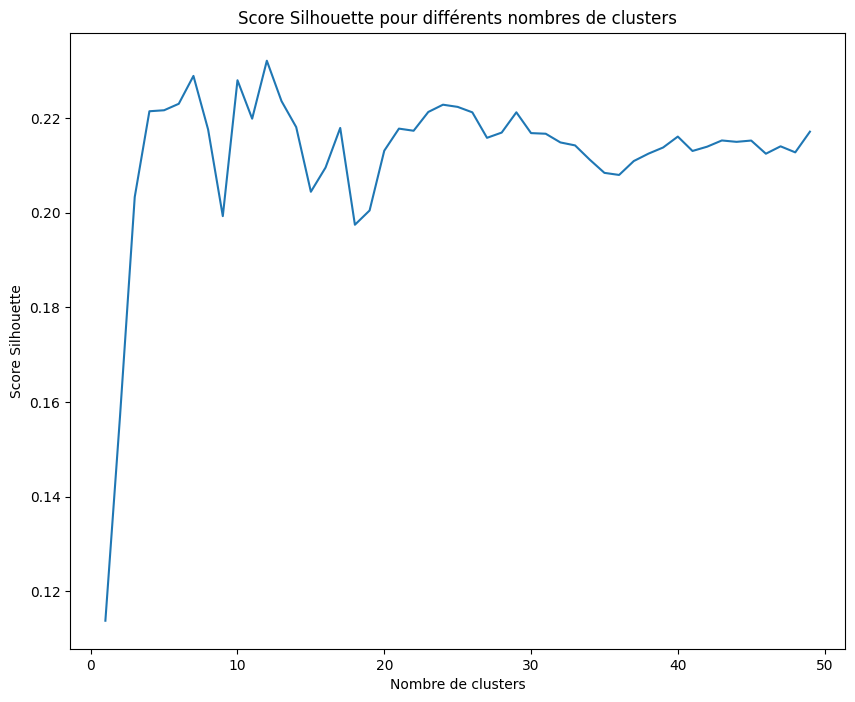

Le nombre optimal de clusters selon le score Silhouette est : 13


In [99]:
# Extraction des identifiants de nœuds et de leurs vecteurs correspondants
node_ids = embeddings.index_to_key  # Identifiants de nœuds à partir des embeddings
vectors = embeddings.vectors  # Vecteurs d'embeddings

# Initialisation des listes pour stocker les résultats
wcss = []
silhouette_scores = []

# Calcul de WCSS pour différents nombres de clusters
for i in range(1, 51): # Test de 1 à 50 clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(vectors)
    wcss.append(kmeans.inertia_)  # Inertie : somme des distances au carré au centre de cluster le plus proche

# Calcul du score Silhouette pour les clusters de taille supérieure à 1
for i in range(2, 51): # Le score Silhouette n'est pas défini pour un seul cluster
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(vectors)
    score = silhouette_score(vectors, kmeans.labels_)
    silhouette_scores.append(score)

# Fonction pour tracer les graphiques
def plot_metric(metric_values, title, x_label, y_label):
    plt.figure(figsize=(10, 8))
    plt.plot(range(1, len(metric_values)+1), metric_values)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

# Tracé du WCSS
plot_metric(wcss, 'Méthode du coude pour le nombre optimal de clusters', 'Nombre de clusters', 'WCSS')

# Tracé du score Silhouette
plot_metric(silhouette_scores, 'Score Silhouette pour différents nombres de clusters', 'Nombre de clusters', 'Score Silhouette')

# Affichage de l'indice de score Silhouette maximum
print('Le nombre optimal de clusters selon le score Silhouette est :', np.argmax(silhouette_scores) + 2)  # +2 car l'indexation commence à 2 clusters


In [130]:
# Choose the number of clusters according to the elbow method
num_clusters = 13 

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(vectors)

# Map nodes to their clusters (communities)
node_to_cluster = {node_id: cluster for node_id, cluster in zip(node_ids, clusters)}

for node_id, cluster in list(node_to_cluster.items())[:10]:  # Print the first 10 for brevity
    print(f"Node: {node_id} -> Cluster: {cluster}")


Node: 3437 -> Cluster: 3
Node: 107 -> Cluster: 6
Node: 1684 -> Cluster: 11
Node: 0 -> Cluster: 9
Node: 1912 -> Cluster: 2
Node: 348 -> Cluster: 12
Node: 686 -> Cluster: 10
Node: 3980 -> Cluster: 7
Node: 414 -> Cluster: 12
Node: 483 -> Cluster: 6


In [131]:
# Calculate community sizes
community_sizes = {i: 0 for i in range(num_clusters)}
for cluster in clusters:
    community_sizes[cluster] += 1

print("Community Sizes:")
for community_nbr, size in community_sizes.items():
    print(f"Community {community_nbr}: {size} nodes")


Community Sizes:
Community 0: 56 nodes
Community 1: 492 nodes
Community 2: 752 nodes
Community 3: 546 nodes
Community 4: 193 nodes
Community 5: 48 nodes
Community 6: 464 nodes
Community 7: 60 nodes
Community 8: 226 nodes
Community 9: 293 nodes
Community 10: 207 nodes
Community 11: 368 nodes
Community 12: 334 nodes


In [132]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt


embeddings_list = np.array(list(vectors))

# Use t-SNE to reduce dimensionality to 2 components for visualization
tsne = TSNE(n_components=2, random_state=7)
embeddings_2d = tsne.fit_transform(embeddings_list)

# Plot the nodes with colors representing their community assignments
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    indices = clusters == i
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=f"Community {i}", alpha=0.7)

plt.title('Node Embeddings Colored by Community (t-SNE)')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()


##Comparaison Louvain avec node2vec + kmeans

In [133]:
converted_node_to_cluster = {}
for node_id_str, cluster in node_to_cluster.items():
    # Convertir la chaîne en entier
    node_id_int = int(node_id_str)
    # Associer l'identifiant de nœud entier avec le cluster original
    converted_node_to_cluster[node_id_int] = cluster

# Vérifier les premiers éléments pour s'assurer que les clusters sont corrects
for node_id, cluster in list(converted_node_to_cluster.items())[:10]:
    print(f"Node: {node_id} -> Cluster: {cluster}")


node_ids = list(converted_node_to_cluster.keys())

Node: 3437 -> Cluster: 3
Node: 107 -> Cluster: 6
Node: 1684 -> Cluster: 11
Node: 0 -> Cluster: 9
Node: 1912 -> Cluster: 2
Node: 348 -> Cluster: 12
Node: 686 -> Cluster: 10
Node: 3980 -> Cluster: 7
Node: 414 -> Cluster: 12
Node: 483 -> Cluster: 6


In [134]:
modularity_louvain = community.modularity(partition, fb)
print(f"Modularité (Louvain): {modularity_louvain}")

# Convertir la partition de K-means en format similaire à celui de Louvain pour le calcul de la modularité
partition_kmeans = {node_id: cluster for node_id, cluster in converted_node_to_cluster.items()}
modularity_kmeans = community.modularity(partition_kmeans, fb)
print(f"Modularité (K-means): {modularity_kmeans}")

# Comparer les partitions à l'aide de l'ARI, du NMI et de la Similarité de Jaccard
# Convertir les partitions en listes d'étiquettes correspondant aux mêmes nœuds
labels_louvain = [partition[node_id] for node_id in node_ids]
labels_kmeans = [converted_node_to_cluster[node_id] for node_id in node_ids]

ari_score = adjusted_rand_score(labels_louvain, labels_kmeans)
nmi_score = normalized_mutual_info_score(labels_louvain, labels_kmeans)
# Pour la similarité de Jaccard, les étiquettes doivent être binarisées.
# jaccard_score nécessite un traitement supplémentaire et est omis ici pour la brièveté.

print(f"ARI: {ari_score}")
print(f"NMI: {nmi_score}")

# Comparer le nombre et la taille des communautés
print(f"Nombre de communautés (Louvain): {len(Counter(partition.values()))}")
print(f"Nombre de communautés (K-means): {num_clusters}")

# Compter les arêtes inter-communautaires
inter_community_edges_kmeans = sum(1 for edge in fb.edges() if converted_node_to_cluster[edge[0]] != converted_node_to_cluster[edge[1]])
print(f"Nombre d'arêtes inter-communautés (K-means): {inter_community_edges_kmeans} Nombre d'aretes inter-communautés (Louvain): {inter_community_edges}")


Modularité (Louvain): 0.8349714021924082
Modularité (K-means): 0.767145131085046
ARI: 0.7366360388153175
NMI: 0.8670102093221265
Nombre de communautés (Louvain): 16
Nombre de communautés (K-means): 13
Nombre d'arêtes inter-communautés (K-means): 3826 Nombre d'aretes inter-communautés (Louvain): 3446


In [21]:
import pandas as pd

# Création d'un DataFrame pour présenter les résultats
data = {
    "Méthode": ["Louvain", "K-means"],
    "Modularité": [0.8349714021924082, 0.767145131085046],
    "Nombre de communautés": [16, 13],
    "Nombre d'arêtes inter-communautés": [3446, 3826],
    "NMI (Normalized Mutual Information)":[0.8670102093221265, 0.8670102093221265]
}

# Ajout des scores ARI et NMI, qui sont des métriques communes à deux méthodes
# Ces valeurs ne sont pas spécifiques à une méthode mais plutôt à la comparaison des deux partitions.
ari = 0.7366360388153175
nmi = 0.8670102093221265

df = pd.DataFrame(data)

# Affichage du DataFrame
df.set_index("Méthode")


Modularité  Nombre de communautés  Nombre d'arêtes inter-communautés  \
Méthode                                                                         
Louvain    0.834971                     16                               3446   
K-means    0.767145                     13                               3826   

         NMI (Normalized Mutual Information)  
Méthode                                       
Louvain                              0.86701  
K-means                              0.86701

En conclusion, bien que les deux méthodes semblent identifier des communautés relativement similaires (comme le montrent le NMI et l'ARI élevés), la méthode de Louvain semble créer des communautés légèrement plus distinctes et compactes en termes de modularité et d'arêtes inter-communautaires. Cependant, K-means reste une méthode solide, surtout lorsque tu utilises des données d'embeddings de nœuds qui peuvent capturer des nuances différentes dans la structure des données.

#prediciton de lien 


In [138]:

#On créer un dataset équilibré avec autant de noeuds possedant un lien que de noeuds n'en possedant pas

# Créer des paires positives (liens existants)
edges = list(G.edges())
positive_samples = [(u, v, 1) for u, v in edges]

# Créer des paires négatives (liens inexistants)
nodes = list(G.nodes())
negative_samples = []
while len(negative_samples) < len(positive_samples):
    u, v = random.sample(nodes, 2)
    if not G.has_edge(u, v):
        negative_samples.append((u, v, 0))

# Fusionner les échantillons et créer un DataFrame
all_samples = positive_samples + negative_samples
random.shuffle(all_samples)  # Mélanger les données
df = pd.DataFrame(all_samples, columns=['node1', 'node2', 'link'])


In [148]:
def get_feature_vector(u, v):
    u_vector = embeddings[str(u)]
    v_vector = embeddings[str(v)]
    # Concaténer les embeddings pour créer un vecteur de caractéristiques
    return np.concatenate([u_vector, v_vector])

# Appliquer la fonction pour créer des caractéristiques
features = df.apply(lambda row: get_feature_vector(row['node1'], row['node2']), axis=1)
X = np.array(features.tolist())
y = df['link'].values


In [159]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Liste des modèles à tester
models = {
    'LogisticRegression': LogisticRegression(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'MLPClassifier': MLPClassifier(random_state=42)
}

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dictionnaire pour les résultats
results = {}

# Formation et évaluation des modèles
for name, model in models.items():
    model.fit(X_train, y_train)  # Formation
    y_pred = model.predict(X_test)  # Prédiction
    print(name)
    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Stocker les résultats dans le dictionnaire
    results[name] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

# Afficher les résultats
for name, metrics in results.items():
    print(f'{name} - Accuracy: {metrics["accuracy"]:.3f}, Precision: {metrics["precision"]:.3f}, '
          f'Recall: {metrics["recall"]:.3f}, F1 Score: {metrics["f1"]:.3f}')


LogisticRegression
RandomForest
GradientBoosting
MLPClassifier
LogisticRegression - Accuracy: 0.689, Precision: 0.692, Recall: 0.685, F1 Score: 0.688
RandomForest - Accuracy: 0.978, Precision: 0.970, Recall: 0.987, F1 Score: 0.978
GradientBoosting - Accuracy: 0.947, Precision: 0.922, Recall: 0.977, F1 Score: 0.948
MLPClassifier - Accuracy: 0.984, Precision: 0.978, Recall: 0.991, F1 Score: 0.985


## maximisation de l'influence avec IC

In [162]:
def compute_independent_cascade(graph, seed_nodes, prob, n_iters=100):
    total_spead = 0

    # simulate the spread process over multiple runs
    for i in range(n_iters):
        np.random.seed(i)
        active = seed_nodes[:]
        new_active = seed_nodes[:]
        
        # for each newly activated nodes, find its neighbors that becomes activated
        while new_active:
            activated_nodes = []
            for node in new_active:
                neighbors = [it for it in graph.neighbors(node)]
                success = np.random.uniform(0, 1, len(neighbors)) < prob
                activated_nodes += list(np.extract(success, neighbors))

            # ensure the newly activated nodes doesn't already exist
            # in the final list of activated nodes before adding them
            # to the final list
            new_active = list(set(activated_nodes) - set(active))
            active += new_active

        total_spead += len(active)

    return total_spead / n_iters

# Test with 1 seed node '0'
seed_nodes = [0]
compute_independent_cascade(fb, seed_nodes, prob=0.2)

3499.06

In [164]:
import time

def greedy(graph, k, prob=0.2, n_iters=100):
    """
    Find k nodes with the largest spread (determined by IC) from a igraph graph
    using the Greedy Algorithm.
    """

    # we will be storing elapsed time and spreads along the way, in a setting where
    # we only care about the final solution, we don't need to record these
    # additional information
    elapsed = []
    spreads = []
    solution = []
    start_time = time.time()

    for i in range(k):
        print(i)
        best_node = -1
        best_spread = -np.inf

        # loop over nodes that are not yet in our final solution
        # to find biggest marginal gain
        nodes = set(list(graph.nodes())) - set(solution)
        for node in nodes:
            spread = compute_independent_cascade(graph, solution + [node], prob, n_iters)
            if spread > best_spread:
                best_spread = spread
                best_node = node

        solution.append(best_node)
        spreads.append(best_spread)

        elapse = round(time.time() - start_time, 3)
        elapsed.append(elapse)

        print(f'k: {i+1}, node: {best_node}, spread: {best_spread}, elapsed: {elapse} sec')

    return solution, spreads, elapsed


k = 5
prob = 0.2
n_iters = 20  # larger number needed to get a more accurate spread vis a vis the size of the graph...
greedy_solution, greedy_spreads, greedy_elapsed = greedy(G, k, prob, n_iters)
print('solution: ', greedy_solution)
print('spreads: ', greedy_spreads)
print('elapsed: ', greedy_elapsed)

0
k: 1, node: 161, spread: 3579.75, elapsed: 4713.267 sec
1
k: 2, node: 837, spread: 3589.75, elapsed: 9902.735 sec
2
k: 3, node: 3980, spread: 3609.75, elapsed: 15178.988 sec
3
k: 4, node: 609, spread: 3619.0, elapsed: 20462.667 sec
4
k: 5, node: 1285, spread: 3618.75, elapsed: 25780.212 sec
solution:  [161, 837, 3980, 609, 1285]
spreads:  [3579.75, 3589.75, 3609.75, 3619.0, 3618.75]
elapsed:  [4713.267, 9902.735, 15178.988, 20462.667, 25780.212]


In [169]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Votre code initial ici pour la définition de G, pos_fb, greedy_solution, etc.

fig = plt.figure(figsize=(10,10))
degree_cent_fb = nx.degree_centrality(G)
nsize = np.array([v for v in degree_cent_fb.values()])
nsize = cte * (nsize  - min(nsize)) / (max(nsize) - min(nsize))

# Ajustement pour augmenter la taille des nœuds des influenceurs
influencer_size_multiplier = 2  # Multiplier pour la taille des nœuds des influenceurs
nsize = [size * influencer_size_multiplier if node in greedy_solution else 1 for node, size in zip(G.nodes(), nsize)]

colors = ['red' if node in greedy_solution else 'blue' for node in G.nodes()]
edge_colors = ['black' if node in greedy_solution else 'none' for node in G.nodes()]  # Bord noir pour les influenceurs

nodes = nx.draw_networkx_nodes(G, pos=pos_fb, node_size=nsize, node_color=colors, edgecolors=edge_colors, linewidths=2)
edges = nx.draw_networkx_edges(G, pos=pos_fb, alpha=.1)
plt.axis('off')
plt.title('Greedy solution')
plt.savefig('graphs/FB/fb_Greedy.png', dpi=300, bbox_inches='tight')
